# 1. Pre-processing
### 1.1. Imports and Setting the path

In [1]:
IMAGE_SIZE = [224, 224]
TRAINING_PATH = '/home/dilara/UGI-endoscopy/training-data'
TESTING_PATH = '/home/dilara/UGI-endoscopy/testing-data'
CLASSES = ['pylorus', 'z-line', 'retroflex-stomach']

import keras
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout 
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sbs

def get_paths(path, class_list):
    all_paths = []
    for landmark in class_list:
        other_path = os.path.join(path, landmark, '*')
        all_paths.append(sorted(glob.glob(other_path)))
    return all_paths

def get_class_num(path):
    len_lis = []
    for lis in path:
        x = 0
        for item in lis:
            x+=1
        len_lis.append(x)
    print(len_lis)
    return len_lis

def create_labels(len_lis, class_list):
    labels_lis = []
    for i in range(len(class_list)):
        labels_lis.append([i] * len_lis[i])
        all_labels = list(np.concatenate(labels_lis).flat)
        all_labels = np.array(all_labels)
    return all_labels

all_paths_train = get_paths(TRAINING_PATH, CLASSES)
all_paths_test = get_paths(TESTING_PATH, CLASSES)
len_lis_train = get_class_num(all_paths_train)
len_lis_test = get_class_num(all_paths_test)

all_paths_train = list(np.concatenate(all_paths_train).flat)
all_paths_test = list(np.concatenate(all_paths_test).flat)

all_labels_train = create_labels(len_lis_train, CLASSES)
all_labels_test = create_labels(len_lis_test, CLASSES)
print(len(all_labels_train))

2022-05-03 10:09:09.190427: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 10:09:09.190454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[6993, 6524, 5348]
[586, 147, 230]
18865


## 1.3. Splitting the Dataset

In [2]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

def get_pix(path_lis):
    pix = []
    for path in path_lis:
        image = load_img(path, color_mode='rgb', target_size=IMAGE_SIZE)
        image = img_to_array(image)
        image = preprocess_input(image)
        pix.append(image)
    return pix

pix_train = get_pix(all_paths_train)
pix_test = get_pix(all_paths_test)
print(len(pix_train))

pix_train = np.array(pix_train)
pix_test = np.array(pix_test)

pix_train, pix_val, label_train, label_val = train_test_split(pix_train, all_labels_train, train_size=0.75, random_state = 42)

label_train = keras.utils.np_utils.to_categorical(label_train, num_classes=len(CLASSES))
label_val = keras.utils.np_utils.to_categorical(label_val, num_classes=len(CLASSES))
label_test = keras.utils.np_utils.to_categorical(all_labels_test, num_classes=len(CLASSES))

18865


# 2. Building the Model

In [3]:
from keras.applications.resnet import ResNet50

resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in resnet.layers:
 layer.trainable = False
 
x = Flatten()(resnet.output)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model.summary()

2022-05-03 10:15:25.071012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-03 10:15:25.071077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-03 10:15:25.071109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-03 10:15:25.073012: W tensorflow/stream_executor/platform

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 3. Training the Model

In [4]:
model_history = model.fit(pix_train, label_train, batch_size=64, epochs=10, validation_data=(pix_val, label_val))

Epoch 1/10


2022-05-03 10:15:42.673806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8518680576 exceeds 10% of free system memory.


222/222 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.9612

2022-05-03 10:20:29.527427: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2840162304 exceeds 10% of free system memory.


222/222 [==============================] - 377s 2s/step - loss: 0.7749 - accuracy: 0.9612 - val_loss: 0.2708 - val_accuracy: 0.9805
Epoch 2/10
222/222 [==============================] - 379s 2s/step - loss: 0.1436 - accuracy: 0.9905 - val_loss: 0.2147 - val_accuracy: 0.9877
Epoch 3/10
222/222 [==============================] - 402s 2s/step - loss: 0.0548 - accuracy: 0.9946 - val_loss: 0.1468 - val_accuracy: 0.9911
Epoch 4/10
222/222 [==============================] - 405s 2s/step - loss: 0.0833 - accuracy: 0.9950 - val_loss: 0.2179 - val_accuracy: 0.9896
Epoch 5/10
222/222 [==============================] - 400s 2s/step - loss: 0.0810 - accuracy: 0.9952 - val_loss: 0.2139 - val_accuracy: 0.9898
Epoch 6/10
222/222 [==============================] - 380s 2s/step - loss: 0.0752 - accuracy: 0.9965 - val_loss: 0.1838 - val_accuracy: 0.9922
Epoch 7/10
222/222 [==============================] - 381s 2s/step - loss: 0.0235 - accuracy: 0.9985 - val_loss: 0.1222 - val_accuracy: 0.9947
Epoch 8/10

## 3.1. Plotting Model History

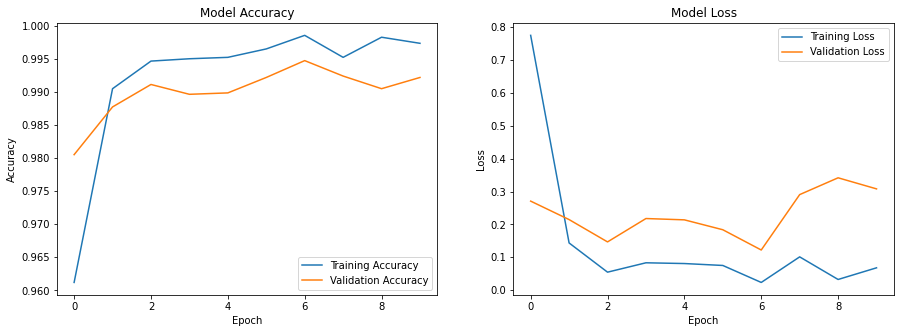

In [5]:

fig, axs = plt.subplots(1,2,figsize=(15,5))

# Summarizing history for accuracy
axs[0].plot(range(0,len(model_history.history['accuracy'])),model_history.history['accuracy'])
axs[0].plot(range(0,len(model_history.history['val_accuracy'])),model_history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

# Summarizing history for loss
axs[1].plot(range(0,len(model_history.history['loss'])),model_history.history['loss'])
axs[1].plot(range(0, len(model_history.history['val_loss'])),model_history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()

# 4. Output Prediction and Evaluation


In [11]:
label_predict = np.argmax(model.predict(pix_val), axis=1)  # returns class values between 0 and 3 from highest prediction
label_true = np.argmax(label_val, axis=1) 
classes = ['pylorus (0)', 'z-line (1)','retroflex-stomach (2)']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=classes))

2022-05-03 12:30:36.731708: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2840162304 exceeds 10% of free system memory.


Classification report:
                        precision    recall  f1-score   support

          pylorus (0)       0.99      0.99      0.99      1748
           z-line (1)       0.99      0.99      0.99      1676
retroflex-stomach (2)       1.00      1.00      1.00      1293

             accuracy                           0.99      4717
            macro avg       0.99      0.99      0.99      4717
         weighted avg       0.99      0.99      0.99      4717



### 4.1. Confusion Matrix

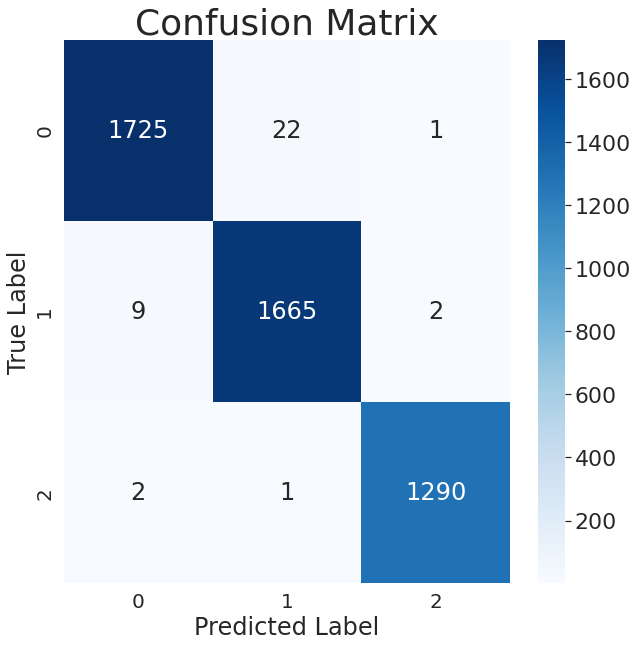

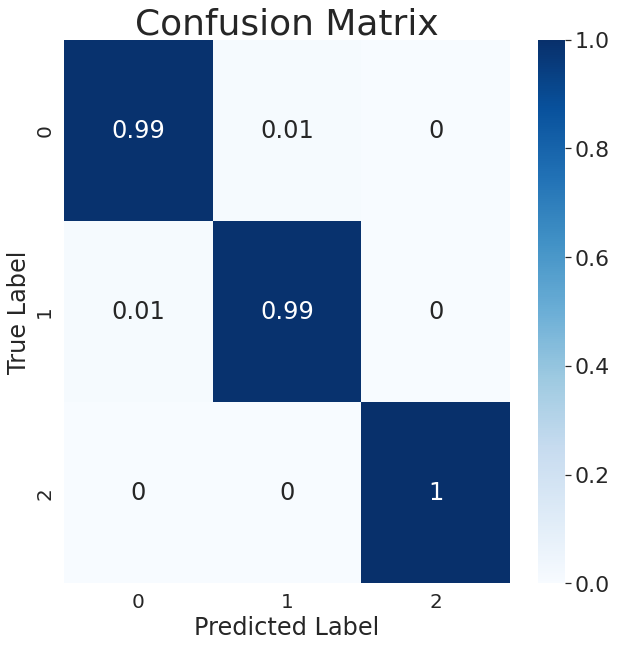

In [12]:
# Source for confusion matrix normalisation:     
# https://stackoverflow.com/questions/59049746/limit-normalised-confusion-matrix-to-2-decimal-points

def generate_cm(label_true, label_predict, norm=True):
    cm = confusion_matrix(label_true, label_predict)
    if norm == True:  
        cm = np.around(cm.astype('float')/cm.sum(axis=1)[:, np.newaxis], decimals=2)
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    sbs.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g")
    sbs.set(font_scale=2) 

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    title_font = {'size':'36'}  
    ax.set_title('Confusion Matrix', fontdict=title_font)
    ax.tick_params(axis='both', which='major', labelsize=20) 
    ax.xaxis.set_ticklabels(['0', '1', '2'])
    ax.yaxis.set_ticklabels(['0', '1', '2'])
    plt.show()

generate_cm(label_true, label_predict, False)
generate_cm(label_true, label_predict)

Classification report:
                        precision    recall  f1-score   support

          pylorus (0)       0.91      0.88      0.89       586
           z-line (1)       0.94      0.43      0.59       147
retroflex-stomach (2)       0.68      0.99      0.81       230

             accuracy                           0.83       963
            macro avg       0.85      0.77      0.76       963
         weighted avg       0.86      0.83      0.83       963



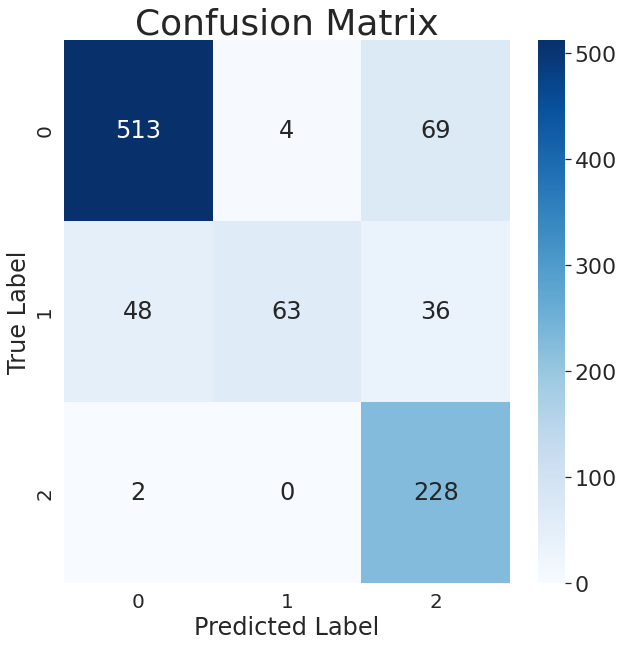

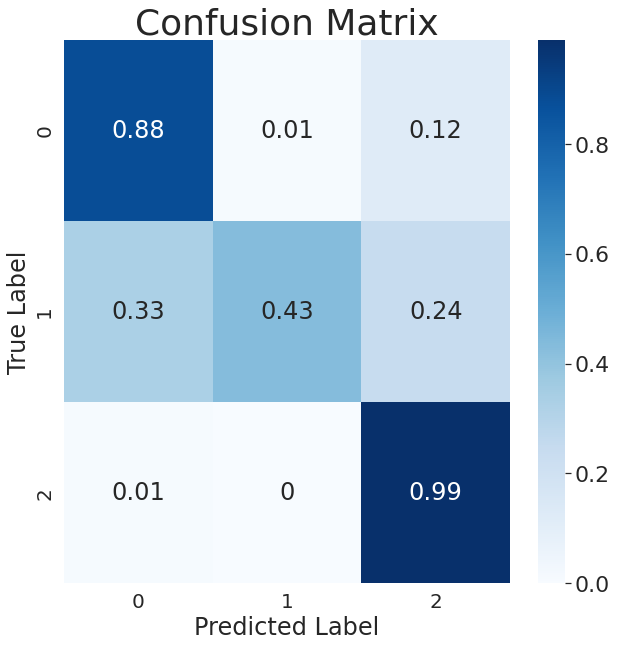

In [8]:
label_predict = np.argmax(model.predict(pix_test), axis=1)  # returns class values between 0 and 3 from highest prediction
label_true = np.argmax(label_test, axis=1) 
classes = ['pylorus (0)', 'z-line (1)','retroflex-stomach (2)']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=classes))
generate_cm(label_true, label_predict, False)
generate_cm(label_true, label_predict)